In [1]:
# import pytorch 
import torch
import torch.nn as nn
import torch.optim as optim

# import other libraries
import tqdm
import matplotlib.pyplot as plt
import numpy as np

# import specific functions
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from torchvision import datasets, transforms

# import custom functions
from interpolate import interpolate

In [2]:
# choose whether to retrain the mnist model and save it or use the saved one
TRAIN = False
SAVE = False

# path to the model saves
PATH = './models/'

## Define basic Autoencoder class and necessary routines

In [3]:
# autoencoder skeleton

class Autoencoder(nn.Module):
    def __init__(self, input_size, num_hidden_layers, hidden_layer_size, bottleneck_size):
        super(Autoencoder, self).__init__()

        # define architecture of the autoencoder
        self.input_size = input_size
        self.num_hidden_layers = num_hidden_layers
        self.hidden_layer_size = hidden_layer_size
        self.bottleneck_size = bottleneck_size

        # construct the encoder and decoder
        self.encoder = self.construct_encoder()
        self.decoder = self.construct_decoder()

        # define loss function and optimizer
        self.loss = nn.MSELoss(reduction='mean')
        self.optimizer = optim.Adam(self.parameters(), lr=0.001)
        
    def construct_encoder(self):
        # construct the encoder
        encoder = nn.Sequential()

        encoder.add_module('input', nn.Linear(self.input_size, self.hidden_layer_size))
        encoder.add_module('relu_input', nn.ReLU())

        for i in range(self.num_hidden_layers - 1):
            encoder.add_module('hidden_' + str(i), nn.Linear(self.hidden_layer_size, self.hidden_layer_size))
            encoder.add_module('relu_' + str(i), nn.ReLU())

        encoder.add_module('bottleneck', nn.Linear(self.hidden_layer_size, self.bottleneck_size))

        return encoder
    
    def construct_decoder(self):
        # construct the decoder
        decoder = nn.Sequential()

        decoder.add_module('input', nn.Linear(self.bottleneck_size, self.hidden_layer_size))
        decoder.add_module('relu_input', nn.ReLU())

        for i in range(self.num_hidden_layers - 1):
            decoder.add_module('hidden_' + str(i), nn.Linear(self.hidden_layer_size, self.hidden_layer_size))
            decoder.add_module('relu_' + str(i), nn.ReLU())

        decoder.add_module('output', nn.Linear(self.hidden_layer_size, self.input_size))

        return decoder
    
    def forward(self, x):
        # forward pass
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [4]:
# define training loop

def train_autoencoder(model, X_train, X_val, n_epochs=10, batch_size=32, verbose=True):
    loss_history = {
        'train': [],
        'val': []
    }
    
    if verbose:
        pbar = tqdm.tqdm(range(n_epochs))
    else:
        pbar = range(n_epochs)

    for epoch in pbar:
        # training
        model.train()
        train_loss = 0
        for i in tqdm.tqdm(range(0, X_train.shape[0], batch_size)):
            batch = X_train[i:i+batch_size]
            model.optimizer.zero_grad()
            output = model(batch)
            loss = model.loss(output, batch)
            loss.backward()
            model.optimizer.step()
            train_loss += loss.item()
        train_loss /= X_train.shape[0]
        loss_history['train'].append(train_loss)

        # validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for i in range(0, X_val.shape[0], batch_size):
                batch = X_val[i:i+batch_size]
                output = model(batch)
                loss = model.loss(output, batch)
                val_loss += loss.item()
        val_loss /= X_val.shape[0]
        loss_history['val'].append(val_loss)

        # print loss
        if verbose:
            pbar.set_description('Epoch: {}/{}, train loss: {:.4f}, val loss: {:.4f}'.format(epoch+1, n_epochs, train_loss, val_loss))
            
    return loss_history

In [5]:
# define function to plot loss history

def plot_loss_history(loss_history):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    epochs_linspace = np.linspace(1, len(loss_history['train']), len(loss_history['train']))

    ax.scatter(epochs_linspace, loss_history['train'], label='train loss', marker='o')
    ax.scatter(epochs_linspace, loss_history['val'], label='val loss', marker='x')

    ax.plot(epochs_linspace, loss_history['train'])
    ax.plot(epochs_linspace, loss_history['val'])

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')

    ax.set_yscale('log')

    ax.grid(alpha=0.35)
    ax.legend()

## Use the Autoencoder for a 2D dataset

In [6]:
dataset_size = 5000

# load data

dataset = make_moons(n_samples=dataset_size, noise=0.1)[0]

# split data into train and validation sets

X_train, X_val = train_test_split(dataset, test_size=0.2)
X_val, X_test = train_test_split(X_val, test_size=0.5)

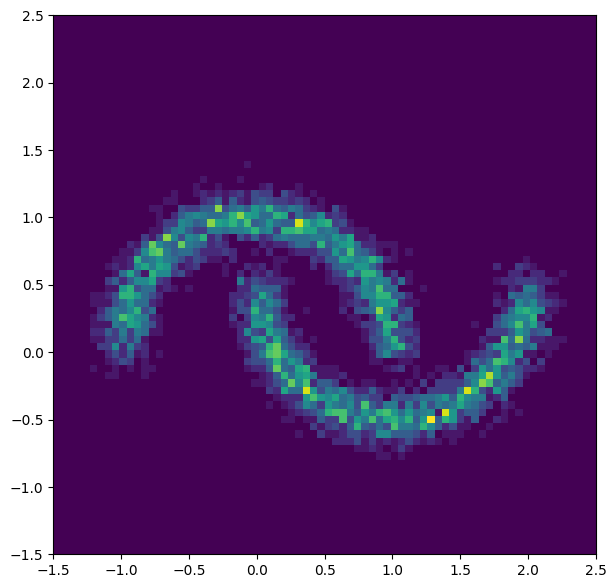

In [7]:
# visualise data as density plot

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

ax.hist2d(dataset[:, 0], dataset[:, 1], bins=np.linspace(-1.5, 2.5, 75));

In [8]:
# architecture of a basic autoencoder

INPUT_SIZE = 2
BOTTLENECK_SIZE = 1
HIDDEN_SIZE = 64
HIDDEN_LAYERS = 4

autoencoder_moons = Autoencoder(INPUT_SIZE, HIDDEN_LAYERS, HIDDEN_SIZE, BOTTLENECK_SIZE)

100%|██████████| 125/125 [00:00<00:00, 283.45it/s]:  96%|█████████▌| 24/25 [00:10<00:00,  2.26it/s]
Epoch: 25/25, train loss: 0.0003, val loss: 0.0003: 100%|██████████| 25/25 [00:10<00:00,  2.32it/s]


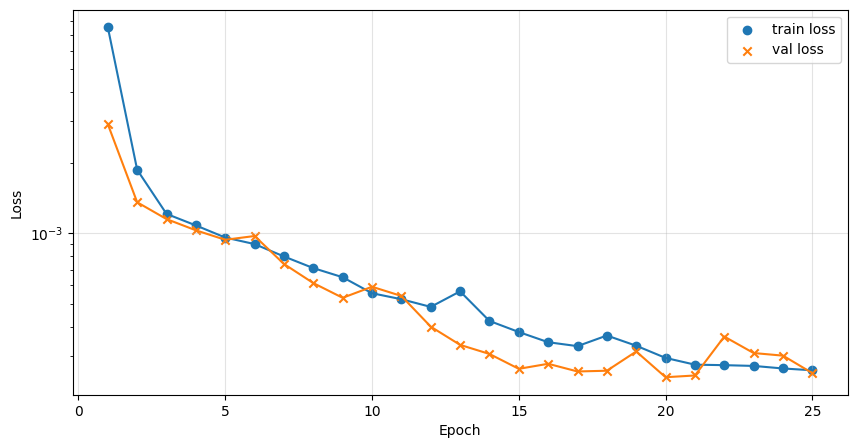

In [9]:
# train autoencoder on the moon dataset

loss_history_moons = train_autoencoder(autoencoder_moons, torch.Tensor(X_train), torch.Tensor(X_val), n_epochs=25, batch_size=32)

# plot loss history

plot_loss_history(loss_history_moons)

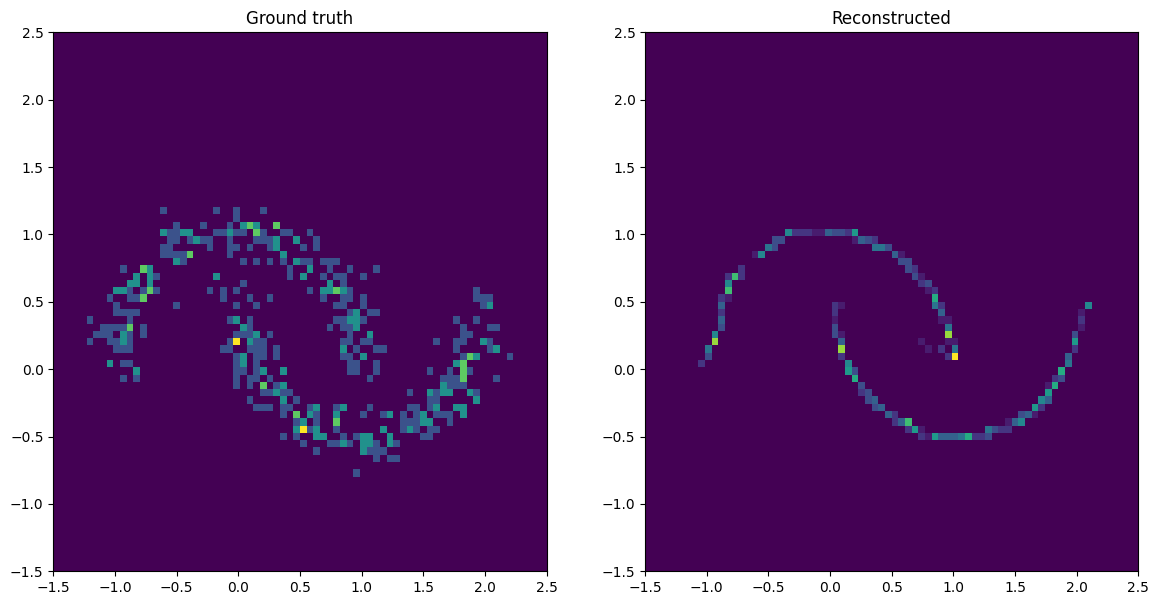

In [10]:
# compare ground truth and reconstructed data of test set
autoencoder_moons.eval()
reconstructed_moons = autoencoder_moons(torch.Tensor(X_test)).detach().numpy()

fig, ax = plt.subplots(1, 2, figsize=(14, 7))

ax[0].hist2d(X_test[:, 0], X_test[:, 1], bins=np.linspace(-1.5, 2.5, 75))
ax[0].set_title('Ground truth')

ax[1].hist2d(reconstructed_moons[:, 0], reconstructed_moons[:, 1], bins=np.linspace(-1.5, 2.5, 75))
ax[1].set_title('Reconstructed');

## More complex example: MNIST

In [11]:
# define convolutional autoencoder

class ConvAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_layer_size, num_hidden_layers, bottleneck_size):
        super(ConvAutoencoder, self).__init__()

        # define architecture of the autoencoder
        self.input_size = input_size
        self.hidden_layer_size = hidden_layer_size
        self.num_hidden_layers = num_hidden_layers
        self.bottleneck_size = bottleneck_size

        self.mnist_size = 28

        # construct the encoder and decoder
        self.encoder = self.construct_encoder()
        self.decoder = self.construct_decoder()

        # define loss function and optimizer
        self.loss = nn.MSELoss(reduction='mean')
        self.optimizer = optim.Adam(self.parameters(), lr=0.001)

    def construct_encoder(self):
        # construct the encoder
        encoder = nn.Sequential()

        encoder.add_module('input', nn.Conv2d(self.input_size, self.hidden_layer_size, kernel_size=3, stride=1, padding=1))
        encoder.add_module('relu_input', nn.ReLU())

        for i in range(self.num_hidden_layers - 1):
            encoder.add_module('hidden_' + str(i), nn.Conv2d(self.hidden_layer_size, self.hidden_layer_size, kernel_size=3, stride=1, padding=1))
            encoder.add_module('relu_' + str(i), nn.ReLU())

        # dense bottleneck layer
        encoder.add_module('flatten', nn.Flatten())
        encoder.add_module('bottleneck', nn.Linear(self.hidden_layer_size * self.mnist_size *self.mnist_size, self.bottleneck_size))

        return encoder
    
    def construct_decoder(self):
        # construct the decoder
        decoder = nn.Sequential()

        decoder.add_module('input', nn.Linear(self.bottleneck_size, self.hidden_layer_size * self.mnist_size * self.mnist_size))
        decoder.add_module('reshape', nn.Unflatten(1, (self.hidden_layer_size, self.mnist_size, self.mnist_size)))
        decoder.add_module('relu_input', nn.ReLU())

        for i in range(self.num_hidden_layers - 1):
            decoder.add_module('hidden_' + str(i), nn.Conv2d(self.hidden_layer_size, self.hidden_layer_size, kernel_size=3, stride=1, padding=1))
            decoder.add_module('relu_' + str(i), nn.ReLU())

        decoder.add_module('output', nn.Conv2d(self.hidden_layer_size, self.input_size, kernel_size=3, stride=1, padding=1))

        return decoder
    
    def forward(self, x):
        # forward pass
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    

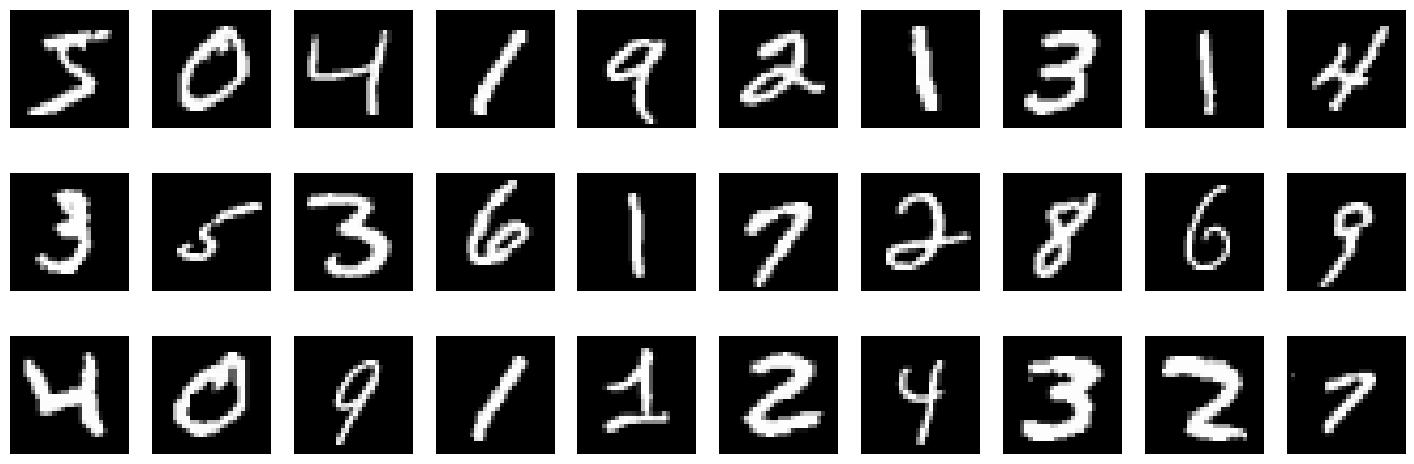

In [12]:
# get MNIST dataset

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

mnist_test_data, mnist_val_data = train_test_split(mnist_test_data, test_size=0.5)

mnist_train = torch.stack([x for x, _ in mnist_train_data])
mnist_test = torch.stack([x for x, _ in mnist_test_data])
mnist_val = torch.stack([x for x, _ in mnist_val_data])

mnist_test_labels = torch.Tensor([y for _, y in mnist_test_data])

# visualise data

fig, ax = plt.subplots(3, 10, figsize=(18, 6))

for i in range(3):
    for j in range(10):
        ax[i, j].imshow(mnist_train[i*10 + j].squeeze(), cmap='gray')
        ax[i, j].axis('off')


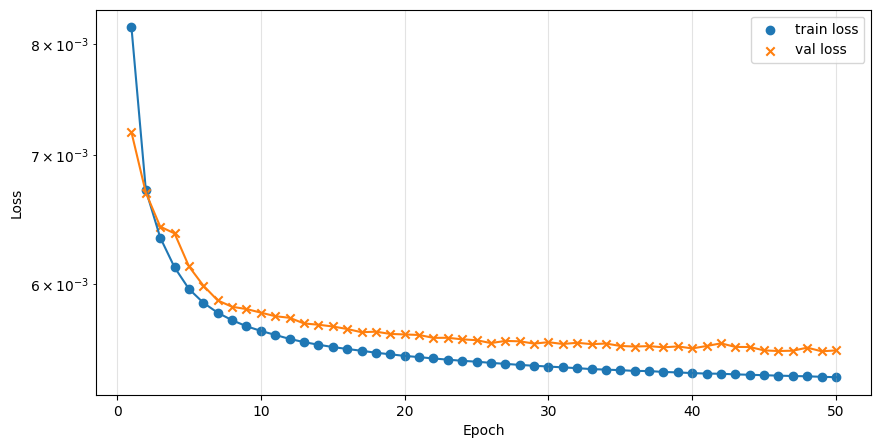

In [13]:
# train autoencoder on MNIST dataset

INPUT_SIZE = 1
BOTTLENECK_SIZE = 2
HIDDEN_SIZE = 4
HIDDEN_LAYERS = 3


if TRAIN:
    conv_autoencoder_mnist = ConvAutoencoder(INPUT_SIZE, HIDDEN_SIZE, HIDDEN_LAYERS, BOTTLENECK_SIZE)
    loss_history_mnist = train_autoencoder(conv_autoencoder_mnist, mnist_train, mnist_val, n_epochs=50, batch_size=32)
    plot_loss_history(loss_history_mnist)
    if SAVE:
        torch.save(conv_autoencoder_mnist.state_dict(), PATH + 'conv_autoencoder_mnist.pt')
        np.save(PATH + 'loss_history_mnist.npy', loss_history_mnist)

else:
    # load pretrained model
    conv_autoencoder_mnist = ConvAutoencoder(INPUT_SIZE, HIDDEN_SIZE, HIDDEN_LAYERS, BOTTLENECK_SIZE)
    conv_autoencoder_mnist.load_state_dict(torch.load(PATH + 'conv_autoencoder_mnist.pt'))
    loss_history_mnist = np.load(PATH + 'loss_history_mnist.npy', allow_pickle=True).item()
    plot_loss_history(loss_history_mnist)

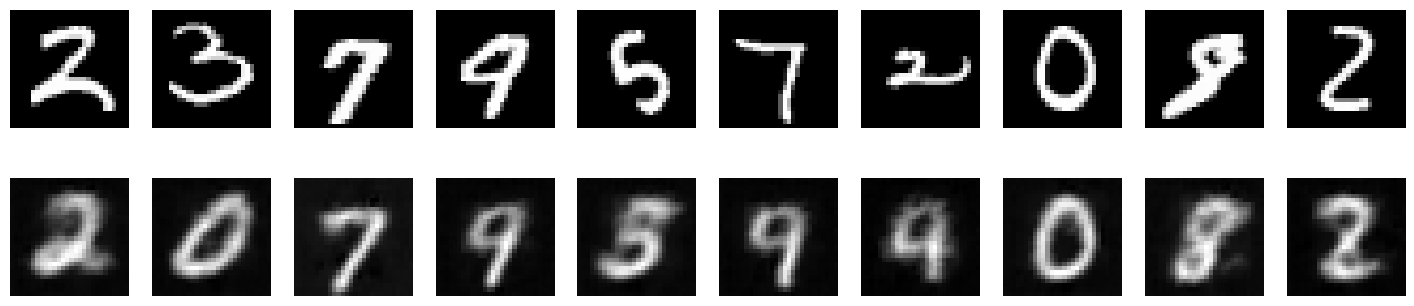

In [14]:
# look at reconstructions of test set

reconstructed_mnist = conv_autoencoder_mnist(mnist_test).detach().numpy()

# compare ground truth and reconstructed data

fig, ax = plt.subplots(2, 10, figsize=(18, 4))

for i in range(10):
    ax[0, i].imshow(mnist_test[i].squeeze(), cmap='gray')
    ax[0, i].axis('off')
    ax[1, i].imshow(reconstructed_mnist[i].squeeze(), cmap='gray')
    ax[1, i].axis('off')


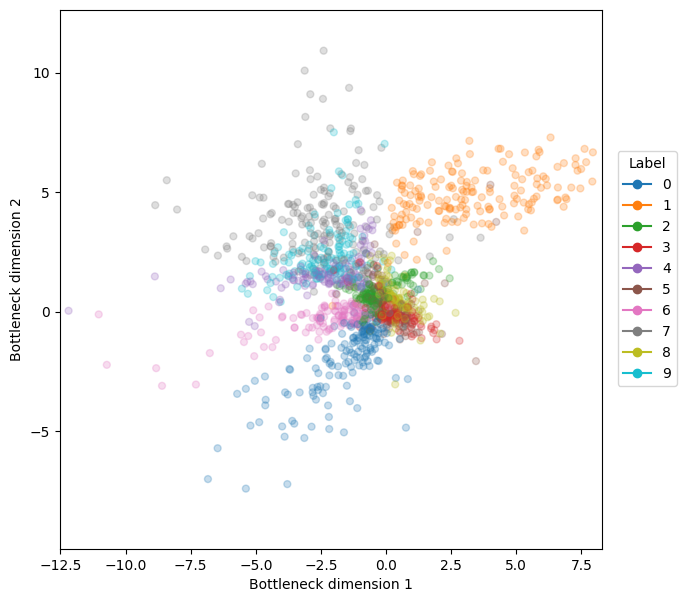

In [15]:
# visualise bottleneck layer with respect to the labels

bottleneck_mnist = conv_autoencoder_mnist.encoder(mnist_test).detach().numpy()

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

ax.scatter(bottleneck_mnist[:1500, 0], bottleneck_mnist[:1500, 1], c=mnist_test_labels[:1500], cmap='tab10', alpha=0.25, marker='.', s=100)

ax.set_xlabel('Bottleneck dimension 1')
ax.set_ylabel('Bottleneck dimension 2')

legend_handeles = []   
for i in range(10):
    legend_handeles.append(plt.Line2D([0], [0], marker='o', color=plt.cm.tab10.colors[i], label=str(i)))

ax.legend(handles=legend_handeles, title='Label', loc='upper right', bbox_to_anchor=(1.15, 0.75))

ax.set_xlim([np.min(bottleneck_mnist[:, 0]), np.max(bottleneck_mnist[:, 0])])
ax.set_ylim([np.min(bottleneck_mnist[:, 1]), np.max(bottleneck_mnist[:, 1])]);

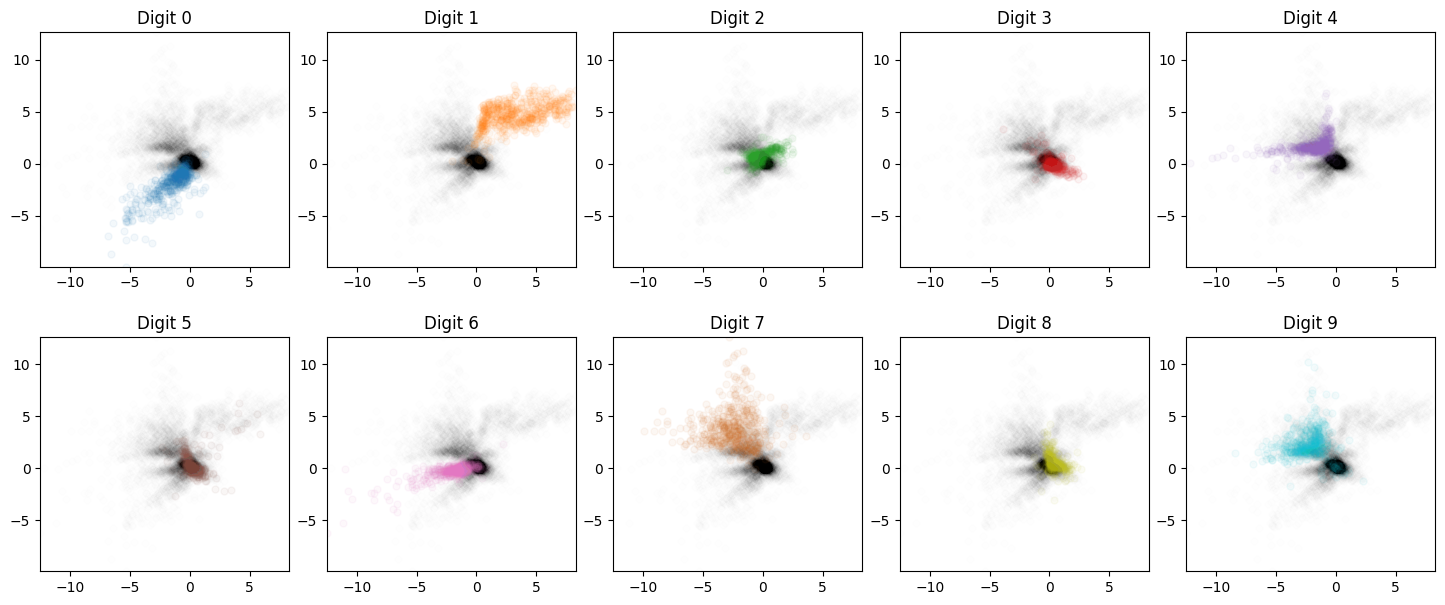

In [16]:
# make subplots for each digit

fig, ax = plt.subplots(2, 5, figsize=(18, 7))

for i in range(10):
    for j in range(10):
        if j != i:
            ax[i//5, i%5].scatter(bottleneck_mnist[mnist_test_labels == j, 0], bottleneck_mnist[mnist_test_labels == j, 1], color='black', alpha=0.005, marker='.', s=100)

    if i != 7:
        ax[i//5, i%5].scatter(bottleneck_mnist[mnist_test_labels == i, 0], bottleneck_mnist[mnist_test_labels == i, 1], color=plt.cm.tab10.colors[i], alpha=0.05, marker='.', s=100)
        ax[i//5, i%5].set_title('Digit {}'.format(i))
    else:
        ax[i//5, i%5].scatter(bottleneck_mnist[mnist_test_labels == i, 0], bottleneck_mnist[mnist_test_labels == i, 1], color='chocolate', alpha=0.05, marker='.', s=100)
        ax[i//5, i%5].set_title('Digit {}'.format(i))

    ax[i//5, i%5].set_xlim([np.min(bottleneck_mnist[:, 0]), np.max(bottleneck_mnist[:, 0])])
    ax[i//5, i%5].set_ylim([np.min(bottleneck_mnist[:, 1]), np.max(bottleneck_mnist[:, 1])])

    fig.subplots_adjust(hspace=0.3)
    fig.subplots_adjust(wspace=0.15)
    

# So, what about data generation?

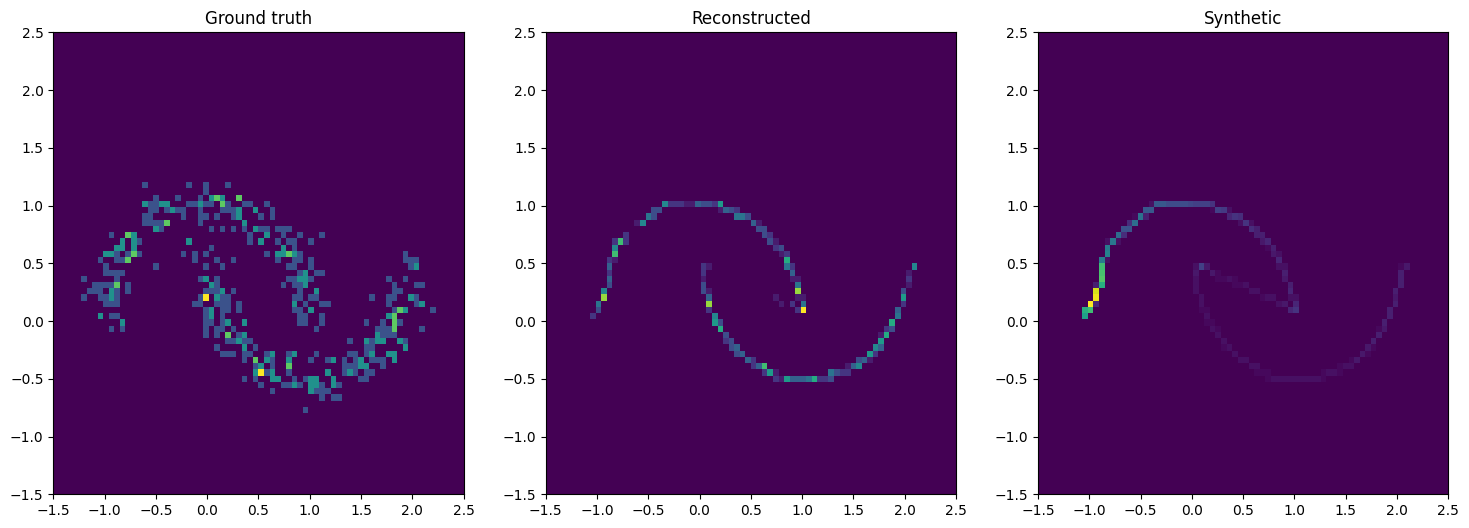

In [17]:
# extract min and max bottleneck values for the moon dataset

bottleneck_moons = autoencoder_moons.encoder(torch.Tensor(X_test)).detach().numpy()

min_bottleneck_moons = np.min(bottleneck_moons, axis=0)
max_bottleneck_moons = np.max(bottleneck_moons, axis=0)

# uniform spaced sampling from the bottleneck space

n_samples = 1000

bottleneck_samples = np.linspace(min_bottleneck_moons, max_bottleneck_moons, n_samples)

# reconstruct samples

reconstructed_samples = autoencoder_moons.decoder(torch.Tensor(bottleneck_samples)).detach().numpy()

# plot ground truth, reconstructions and synthetic data

fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].hist2d(X_test[:, 0], X_test[:, 1], bins=np.linspace(-1.5, 2.5, 75))
ax[0].set_title('Ground truth')

ax[1].hist2d(reconstructed_moons[:, 0], reconstructed_moons[:, 1], bins=np.linspace(-1.5, 2.5, 75))
ax[1].set_title('Reconstructed')

ax[2].hist2d(reconstructed_samples[:, 0], reconstructed_samples[:, 1], bins=np.linspace(-1.5, 2.5, 75))
ax[2].set_title('Synthetic');

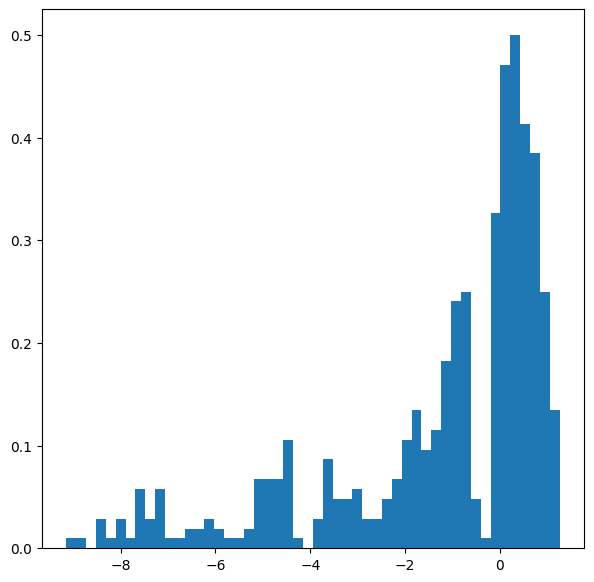

In [18]:
# take a look at the 1D bottleneck of the moon dataset

bottleneck_moons = autoencoder_moons.encoder(torch.Tensor(X_test)).detach().numpy()

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

ax.hist(bottleneck_moons, bins=50, color='tab:blue', density=True);

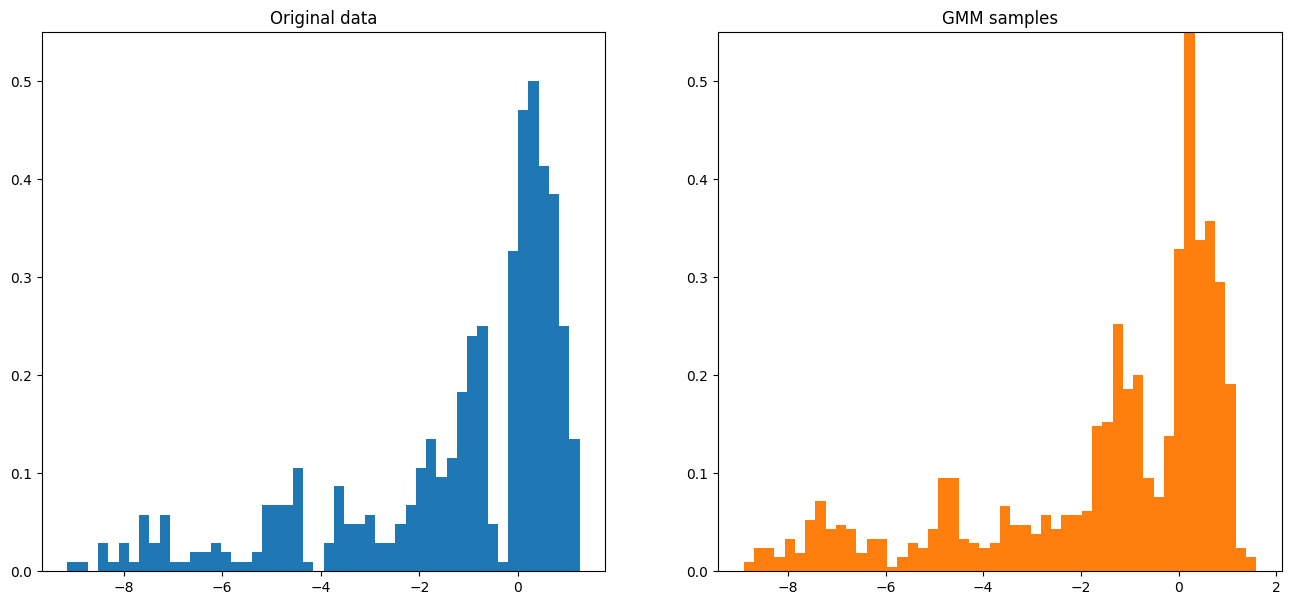

In [19]:
# and fit a Gaussian mixture model to it

from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=6, covariance_type='full')

gmm.fit(bottleneck_moons)

# plot the original data and the samples from the GMM 

fig, ax = plt.subplots(1, 2, figsize=(16, 7))

ax[0].hist(bottleneck_moons, bins=50, color='tab:blue', density=True)
ax[0].set_ylim(0, 0.55)
ax[0].set_title('Original data')

ax[1].hist(gmm.sample(1000)[0], bins=50, color='tab:orange', density=True)
ax[1].set_ylim(0, 0.55)
ax[1].set_title('GMM samples');

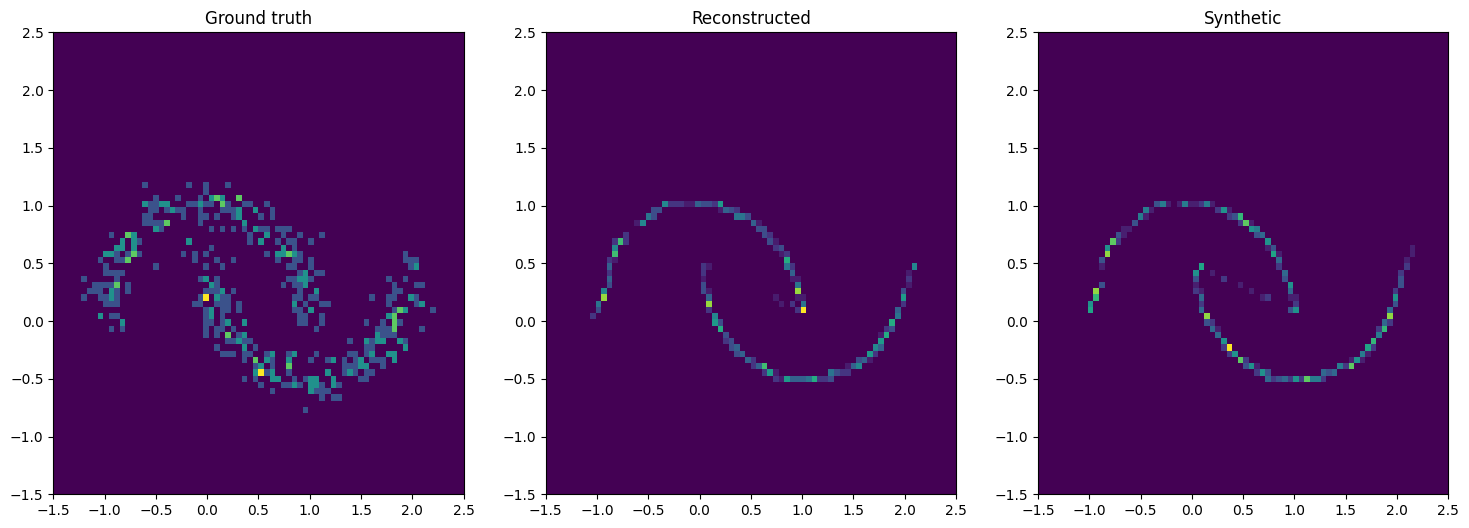

In [20]:
# sample from the GMM and decode the samples

samples = gmm.sample(len(X_test))[0]

samples = torch.Tensor(samples)

generated_samples = autoencoder_moons.decoder(samples).detach().numpy()

# plot the ground truth, reconstructions an sythetic data

fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].hist2d(X_test[:, 0], X_test[:, 1], bins=np.linspace(-1.5, 2.5, 75))
ax[0].set_title('Ground truth')

ax[1].hist2d(reconstructed_moons[:, 0], reconstructed_moons[:, 1], bins=np.linspace(-1.5, 2.5, 75))
ax[1].set_title('Reconstructed')

ax[2].hist2d(generated_samples[:, 0], generated_samples[:, 1], bins=np.linspace(-1.5, 2.5, 75))
ax[2].set_title('Synthetic');

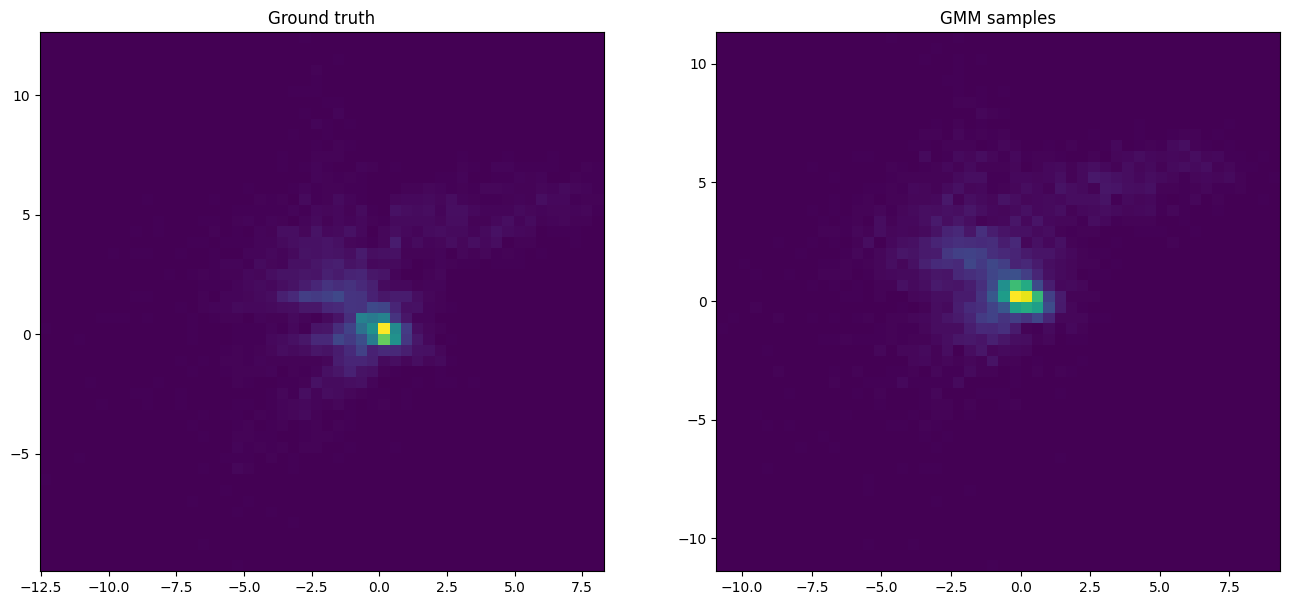

In [21]:
# do the same for the MNIST dataset

bottleneck_mnist = conv_autoencoder_mnist.encoder(mnist_test).detach().numpy()

fig, ax = plt.subplots(1, 2, figsize=(16, 7))

ax[0].hist2d(bottleneck_mnist[:, 0], bottleneck_mnist[:, 1], bins=50)
ax[0].set_title('Ground truth')

gmm_mnist = GaussianMixture(n_components=10, covariance_type='full')
gmm_mnist.fit(bottleneck_mnist)

generated_samples = gmm_mnist.sample(len(mnist_test))[0]

ax[1].hist2d(generated_samples[:, 0], generated_samples[:, 1], bins=50)
ax[1].set_title('GMM samples');

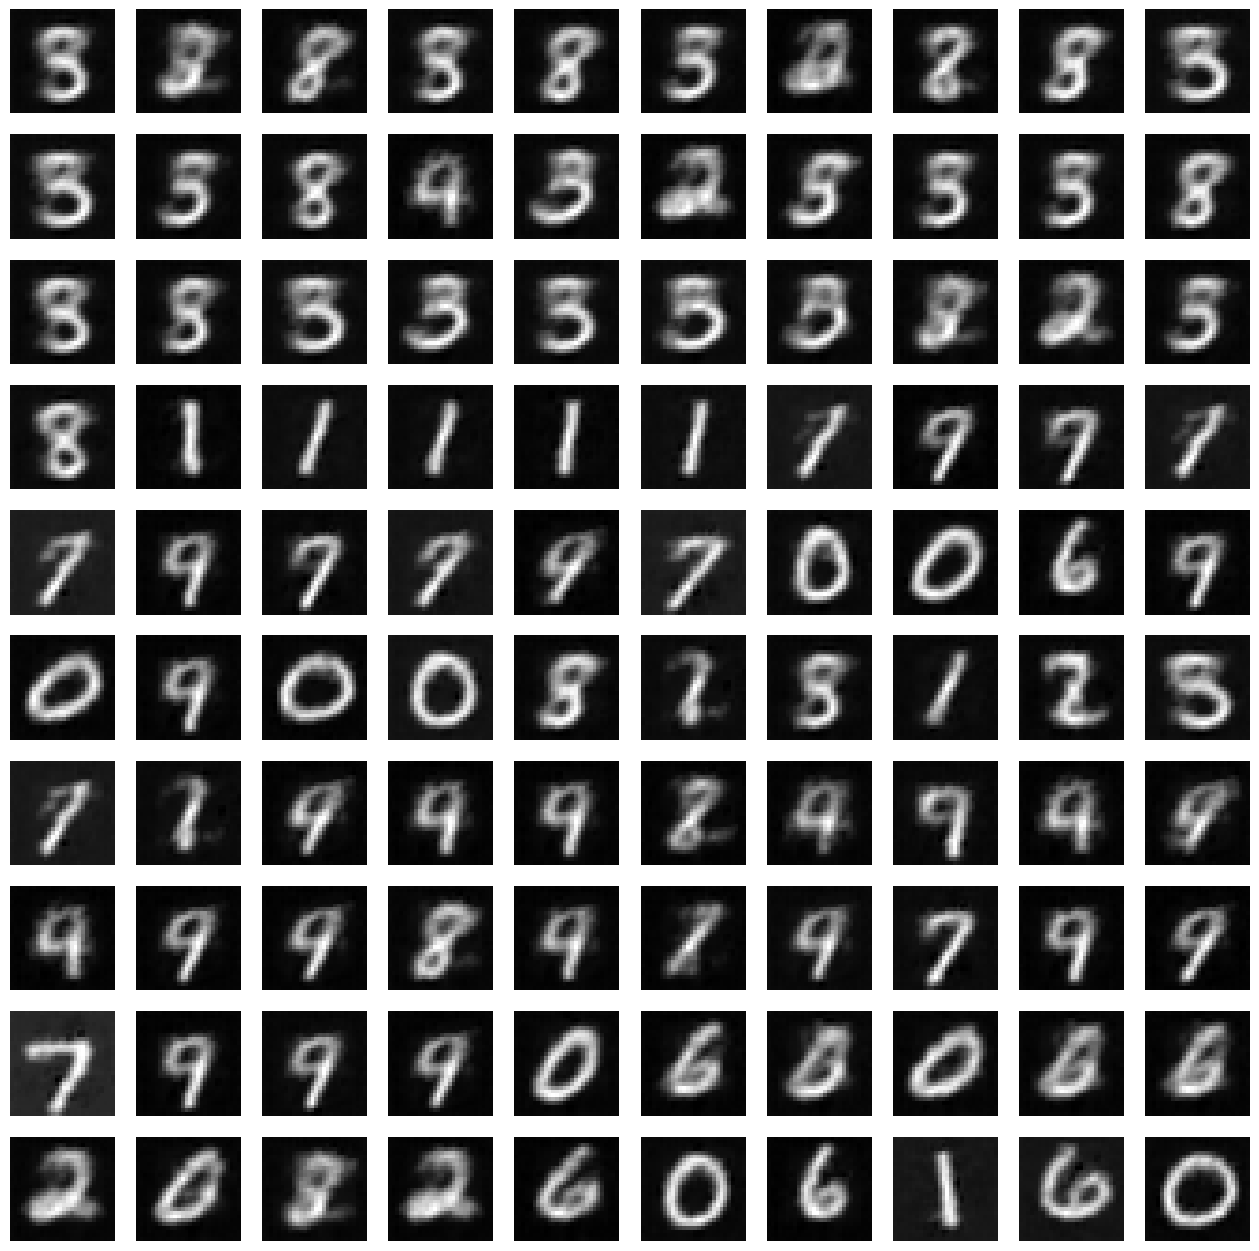

In [22]:
# generate 100 samples from the GMM and decode them

samples = gmm_mnist.sample(100)[0]

samples = torch.Tensor(samples)

generated_samples = conv_autoencoder_mnist.decoder(samples).detach().numpy()

# plot the sythetic data

fig, ax = plt.subplots(10, 10, figsize=(16, 16))

for i in range(10):
    for j in range(10):
        ax[i, j].imshow(generated_samples[i*10 + j].squeeze(), cmap='gray')
        ax[i, j].axis('off')

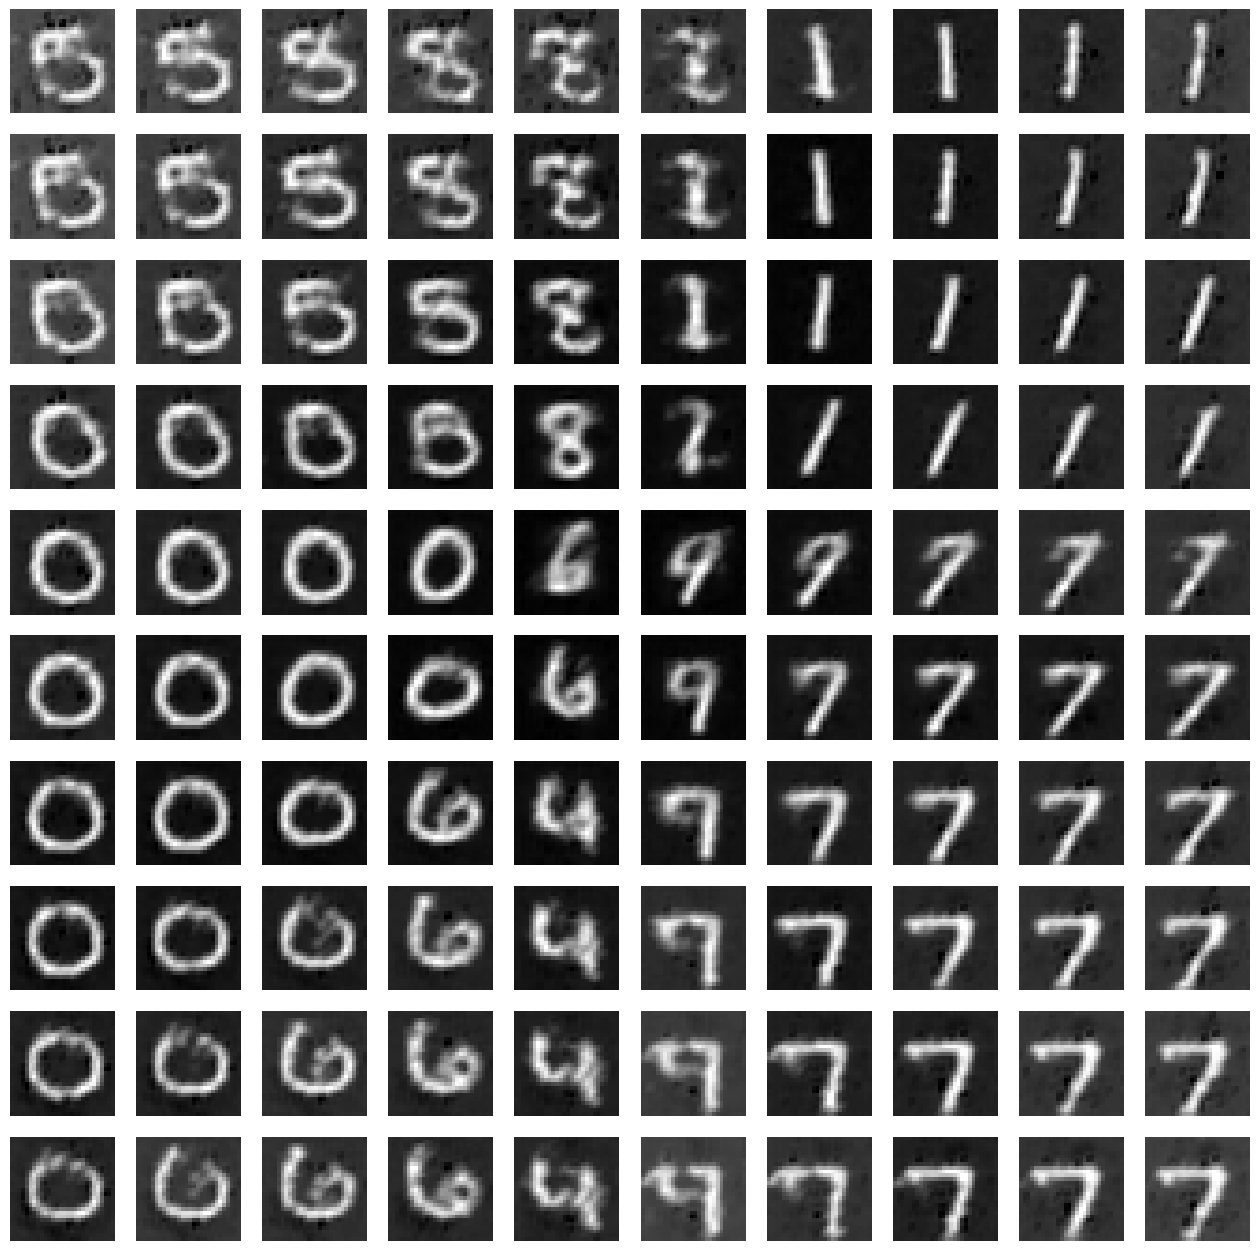

In [23]:
# generate 100 bottleneck sampled in a grid from max and min values of the bottleneck array

x = np.linspace(np.max(bottleneck_mnist[:, 0]), np.min(bottleneck_mnist[:, 0]), 10)
y = np.linspace(np.min(bottleneck_mnist[:, 1]), np.max(bottleneck_mnist[:, 1]), 10)

samples = np.zeros((100, 2))

for i in range(10):
    for j in range(10):
        samples[i*10 + j, 0] = x[i]
        samples[i*10 + j, 1] = y[j]

samples = torch.Tensor(samples)

generated_samples = conv_autoencoder_mnist.decoder(samples).detach().numpy()

# plot the sythetic data

fig, ax = plt.subplots(10, 10, figsize=(16, 16))

for i in range(10):
    for j in range(10):
        ax[i, j].imshow(generated_samples[i*10 + j].squeeze(), cmap='gray')
        ax[i, j].axis('off')


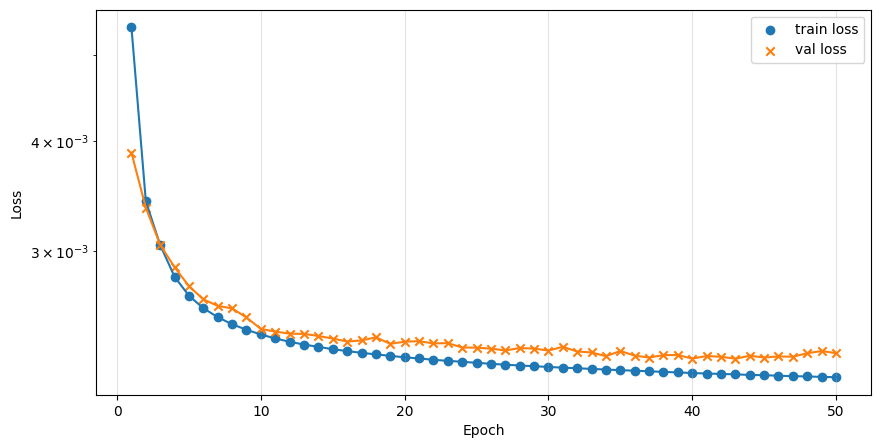

In [24]:
# repeat the MNIST example with a bottleneck size of 8

INPUT_SIZE = 1
BOTTLENECK_SIZE = 8
HIDDEN_SIZE = 4
HIDDEN_LAYERS = 3


if TRAIN:
    conv_autoencoder_mnist_8 = ConvAutoencoder(INPUT_SIZE, HIDDEN_SIZE, HIDDEN_LAYERS, BOTTLENECK_SIZE)
    loss_history_mnist_8 = train_autoencoder(conv_autoencoder_mnist_8, mnist_train, mnist_val, n_epochs=50, batch_size=32)
    plot_loss_history(loss_history_mnist)
    if SAVE:
        torch.save(conv_autoencoder_mnist_8.state_dict(), PATH + 'conv_autoencoder_mnist_8.pt')
        np.save(PATH + 'loss_history_mnist_8.npy', loss_history_mnist_8)

else:
    # load pretrained model
    conv_autoencoder_mnist_8 = ConvAutoencoder(INPUT_SIZE, HIDDEN_SIZE, HIDDEN_LAYERS, BOTTLENECK_SIZE)
    conv_autoencoder_mnist_8.load_state_dict(torch.load(PATH + 'conv_autoencoder_mnist_8.pt'))
    loss_history_mnist_8 = np.load(PATH + 'loss_history_mnist_8.npy', allow_pickle=True).item()
    plot_loss_history(loss_history_mnist_8)


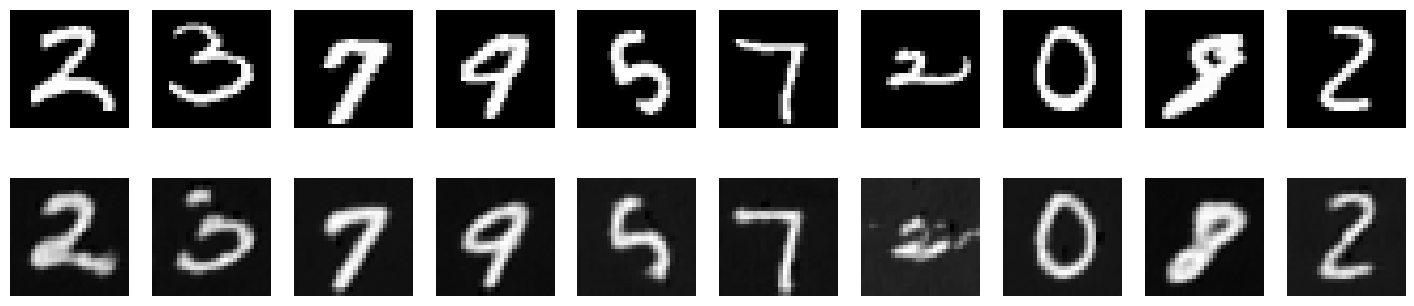

In [25]:
# look at reconstructions of test set

reconstructed_mnist = conv_autoencoder_mnist_8(mnist_test).detach().numpy()

# compare ground truth and reconstructed data

fig, ax = plt.subplots(2, 10, figsize=(18, 4))

for i in range(10):
    ax[0, i].imshow(mnist_test[i].squeeze(), cmap='gray')
    ax[0, i].axis('off')
    ax[1, i].imshow(reconstructed_mnist[i].squeeze(), cmap='gray')
    ax[1, i].axis('off')

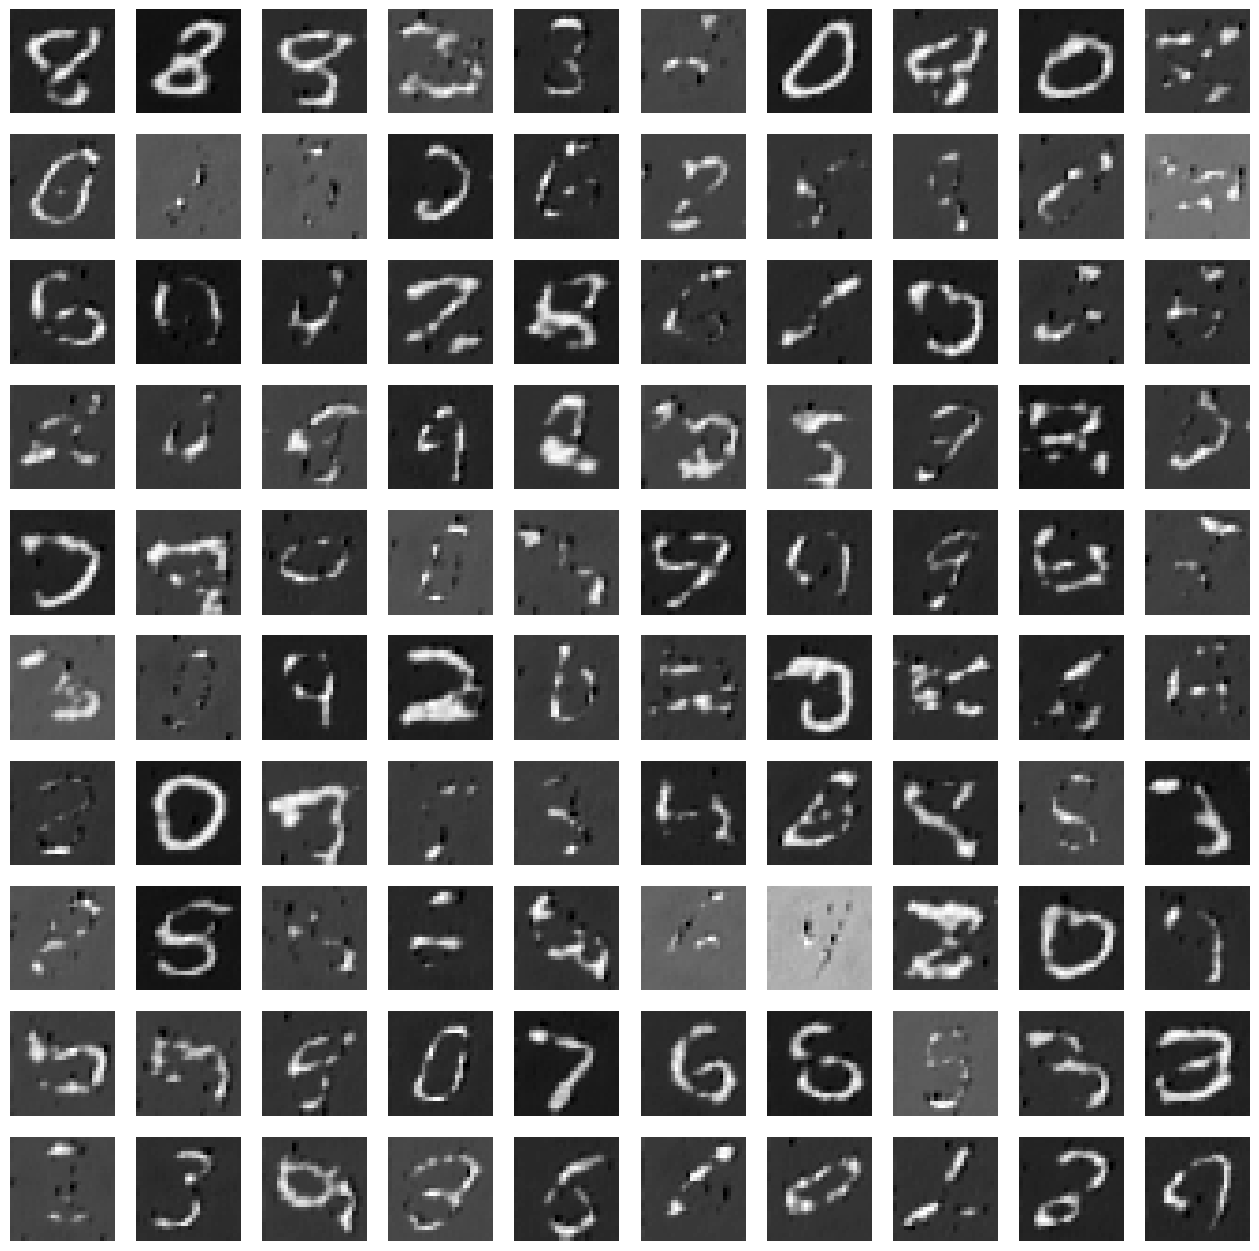

In [26]:
# do random uniform sampling from the bottleneck layer in the max value ranges for each dimension

bottleneck_mnist = conv_autoencoder_mnist_8.encoder(mnist_test).detach().numpy()

max_values = np.max(bottleneck_mnist, axis=0)
min_values = np.min(bottleneck_mnist, axis=0)

samples = torch.rand(100, 8) * (max_values - min_values) + min_values

generated_samples = conv_autoencoder_mnist_8.decoder(samples)

# plot the sythetic data

fig, ax = plt.subplots(10, 10, figsize=(16, 16))

for i in range(10):
    for j in range(10):
        ax[i, j].imshow(generated_samples[i*10 + j].detach().numpy().squeeze(), cmap='gray')
        ax[i, j].axis('off')